**UnZip the Dataset**

In [ ]:
import zipfile
import os

# Define the zip file path and destination folder
zip_path = "/content/Monkeypox Skin Image Dataset (2).zip"
extract_to = "/content/Monkeypox_Skin_Image_Dataset"

# Create the destination folder if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted to: {extract_to}")


Extracted to: /content/Monkeypox_Skin_Image_Dataset


**Import The Libraries**

In [ ]:
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import plotly.express as px

**CSV FILE CREATED**

In [ ]:
import os
import csv

# Define the folder path and output CSV file
folder_path = "/content/Monkeypox_Skin_Image_Dataset/Monkeypox Skin Image Dataset"
csv_file = "/content/dataset.csv"

# Collect data from the folder
data = []
for root, _, files in os.walk(folder_path):
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
            file_path = os.path.join(root, file)
            label = os.path.basename(root)  # Use folder name as label
            data.append([file, file_path, label])

# Write data to CSV
with open(csv_file, 'w', newline='') as f:
    writer = csv.writer(f)
    # Write the header
    writer.writerow(["File Name", "File Path", "Class Label"])
    # Write the rows
    writer.writerows(data)

print(f"CSV file created at: {csv_file}")


CSV file created at: /content/dataset.csv


**Distribution of the Class**

In [ ]:
# Loading the dataset metadata and visualizing class distribution
info_file = '/content/dataset.csv'
info = pd.read_csv(info_file)
info.head()

fig = px.pie(
    names=info['Class Label'].unique(),  # Access the column using ['Class Label']
    values=info['Class Label'].value_counts(),  # Access the column using ['Class Label']
    hole=0.2,
    width=500,
    height=500
)
fig.update_layout({'title': {'text': 'Distribution of the Class', 'x': 0.45}})
fig.show()

**SPLIT THE DATASET INTO TRAIN AND TEST**

In [ ]:
import tensorflow as tf
import os

# Define dataset path
tpath = "/content/Monkeypox_Skin_Image_Dataset/Monkeypox Skin Image Dataset"  # Path to the dataset
output_train_path = "/content/Monkeypox_Skin_Image_Dataset/split/train"
output_test_path = "/content/Monkeypox_Skin_Image_Dataset/split/test"

# Create output directories if they don't exist
os.makedirs(output_train_path, exist_ok=True)
os.makedirs(output_test_path, exist_ok=True)

# Define parameters
batch_size = 32
image_height, image_width = 256, 256
test_split = 0.2  # 20% of data for testing

# Load the full dataset with shuffle and batch_size > 1
full_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    tpath,
    batch_size=batch_size,  # Process multiple images at a time
    image_size=(image_height, image_width),
    shuffle=True,
    seed=123  # Ensure reproducibility
)

# Get the class names
class_names = full_dataset.class_names

# Calculate sizes for train and test
dataset_size = len(full_dataset) * batch_size  # Total images in the dataset
test_size = int(test_split * dataset_size)
train_size = dataset_size - test_size

# Split the dataset using `unbatch` to handle each image individually
full_dataset = full_dataset.unbatch()  # Break the batches into individual samples
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

# Helper function to save a dataset and count images
def save_and_count_dataset(dataset, output_path):
    image_count = 0  # Counter for total images saved
    for img, label in dataset:
        label_name = class_names[label.numpy()]
        # Create a directory for each class
        class_dir = os.path.join(output_path, label_name)
        os.makedirs(class_dir, exist_ok=True)
        # Save the image
        img_path = os.path.join(class_dir, f"img_{image_count}.jpeg")
        tf.keras.preprocessing.image.save_img(img_path, img.numpy())
        image_count += 1  # Increment the image count
    return image_count

# Save train and test datasets and count the images
print("Saving and counting train dataset...")
train_image_count = save_and_count_dataset(train_dataset, output_train_path)

print("Saving and counting test dataset...")
test_image_count = save_and_count_dataset(test_dataset, output_test_path)

# Print the total image counts
print(f"Total images in train dataset: {train_image_count}")
print(f"Total images in test dataset: {test_image_count}")
print("Datasets have been saved!")


Found 600 files belonging to 2 classes.
Saving and counting train dataset...
Saving and counting test dataset...
Total images in train dataset: 487
Total images in test dataset: 113
Datasets have been saved!


**AUGMENTATION OF TRAIN DATASET**

In [ ]:
import tensorflow as tf
import os

# Define dataset paths
train_path = "/content/Monkeypox_Skin_Image_Dataset/split/train"
augmented_data_path = "/content/Monkeypox_Skin_Image_Dataset/augmented_train"

# Parameters
image_height, image_width = 256, 256
augmentations_per_image = 5  # Including the original, 5 images per original

# Create a directory for augmented data
os.makedirs(augmented_data_path, exist_ok=True)

# Define an ImageDataGenerator for augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,       # Randomly rotate images
    width_shift_range=0.2,   # Randomly shift images horizontally
    height_shift_range=0.2,  # Randomly shift images vertically
    shear_range=0.2,         # Shear transformations
    zoom_range=0.2,          # Zoom in/out
    horizontal_flip=True,    # Randomly flip images horizontally
    fill_mode='nearest'      # Fill in pixels with nearest value
)

augmented_image_count = 0  # Variable to track total augmented images
original_image_count = 0  # Variable to track total original images

# Iterate through both classes (monkeypox, normal) and augment each image
for class_name in os.listdir(train_path):  # Iterate over class subfolders (monkeypox, normal)
    class_dir = os.path.join(train_path, class_name)
    augmented_class_dir = os.path.join(augmented_data_path, class_name)
    os.makedirs(augmented_class_dir, exist_ok=True)

    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        img = tf.keras.utils.load_img(img_path, target_size=(image_height, image_width))  # Load image
        img_array = tf.keras.utils.img_to_array(img)  # Convert to array
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the generator

        # Save the original image in the augmented directory
        original_img_path = os.path.join(augmented_class_dir, img_file)  # Save the original
        tf.keras.preprocessing.image.save_img(original_img_path, img_array[0])  # Save original image
        original_image_count += 1  # Increment for the original image

        # Generate augmentations (4 new images for a total of 5)
        i = 0
        for batch in datagen.flow(img_array, batch_size=1, save_to_dir=augmented_class_dir, save_prefix='aug', save_format='jpeg'):
            i += 1
            augmented_image_count += 1  # Increment for each augmented image
            if i >= augmentations_per_image - 1:  # Stop after 4 augmentations (total 5 including original)
                break

# Debugging: Output the counts for original and augmented images
print(f"Total original images saved: {original_image_count}")
print(f"Total augmented images generated: {augmented_image_count}")
print(f"Total images (original + augmented): {original_image_count + augmented_image_count}")


Total original images saved: 487
Total augmented images generated: 1948
Total images (original + augmented): 2435


**SPLIT THE AUGMENTED DATASET INTO TRAIN & VALIDATION**

In [ ]:
import os
import shutil
import random

# Define augmented dataset path
augmented_data_path = "/content/Monkeypox_Skin_Image_Dataset/augmented_train"
output_train_val_path = "/content/Monkeypox_Skin_Image_Dataset/split/train_val"
output_validation_path = "/content/Monkeypox_Skin_Image_Dataset/split/validation"

# Create output directories if they don't exist
os.makedirs(output_train_val_path, exist_ok=True)
os.makedirs(output_validation_path, exist_ok=True)

# Parameters
validation_split = 0.2  # 20% for validation, 80% for training

# Helper function to split dataset
def split_dataset(class_name, class_dir, train_val_dir, val_dir, split_ratio):
    # List all images in the class directory
    all_images = [f for f in os.listdir(class_dir) if f.endswith('.jpeg')]

    # Calculate how many images should go to the validation set
    val_count = int(len(all_images) * split_ratio)

    # Randomly shuffle images
    random.shuffle(all_images)

    # Split into training and validation
    val_images = all_images[:val_count]
    train_val_images = all_images[val_count:]

    # Create class directories for train/val sets if not exist
    os.makedirs(os.path.join(train_val_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

    # Move images to train_val and validation directories
    for img in train_val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(train_val_dir, class_name, img))

    for img in val_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(val_dir, class_name, img))

    print(f"Class '{class_name}' split into {len(train_val_images)} training and {len(val_images)} validation images.")

# Iterate over each class (monkeypox, normal) and split the augmented dataset
for class_name in os.listdir(augmented_data_path):
    class_dir = os.path.join(augmented_data_path, class_name)
    if os.path.isdir(class_dir):  # Only process directories
        split_dataset(class_name, class_dir, output_train_val_path, output_validation_path, validation_split)

print("Augmented dataset split into train/validation sets successfully.")


Class 'Non-MonkeyPox' split into 888 training and 221 validation images.
Class 'Monkeypox' split into 989 training and 247 validation images.
Augmented dataset split into train/validation sets successfully.


**Normalization**

In [ ]:
import os
import tensorflow as tf

# Define input dataset paths
dataset_paths = {
    "train": "/content/Monkeypox_Skin_Image_Dataset/split/train_val",
    "test": "/content/Monkeypox_Skin_Image_Dataset/split/test",
    "validation": "/content/Monkeypox_Skin_Image_Dataset/split/validation"
}

# Define output paths for normalized datasets
normalized_base_path = "/content/Monkeypox_Skin_Image_Dataset/normalized"
normalized_paths = {key: os.path.join(normalized_base_path, key) for key in dataset_paths}

# Create output directories
for path in normalized_paths.values():
    os.makedirs(path, exist_ok=True)

# Function to normalize and save images
def normalize_and_save_images(input_path, output_path):
    image_count = 0
    for root, _, files in os.walk(input_path):
        for file in files:
            if file.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):  # Support multiple formats
                # Load the image
                img_path = os.path.join(root, file)
                img = tf.keras.preprocessing.image.load_img(img_path)
                img_array = tf.keras.preprocessing.image.img_to_array(img)

                # Normalize the image (scale pixel values to [0,1])
                normalized_img_array = img_array / 255.0

                # Create output directory structure
                relative_dir = os.path.relpath(root, input_path)
                output_subdir = os.path.join(output_path, relative_dir)
                os.makedirs(output_subdir, exist_ok=True)

                # Save the normalized image
                normalized_img_path = os.path.join(output_subdir, file)
                tf.keras.preprocessing.image.save_img(
                    normalized_img_path,
                    normalized_img_array
                )
                image_count += 1
    return image_count

# Normalize and save all datasets
for dataset_name, input_path in dataset_paths.items():
    print(f"Normalizing {dataset_name} dataset...")
    count = normalize_and_save_images(input_path, normalized_paths[dataset_name])
    print(f"Total normalized images in {dataset_name} dataset: {count}")

print("✅ Normalization completed for all datasets!")


Normalizing train dataset...
Total normalized images in train dataset: 1877
Normalizing test dataset...
Total normalized images in test dataset: 113
Normalizing validation dataset...
Total normalized images in validation dataset: 468
✅ Normalization completed for all datasets!


**MultiheadAttention in ResNet50**

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Found 1877 files belonging to 2 classes.
Found 468 files belonging to 2 classes.
Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 41s 406ms/step - accuracy: 0.6527 - loss: 0.6723 - val_accuracy: 0.7756 - val_loss: 0.6181
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - accuracy: 0.7882 - loss: 0.5962 - val_accuracy: 0.8013 - val_loss: 0.5499
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 119ms/step - accuracy: 0.8252 - loss: 0.5224 - val_accuracy: 0.8397 - val_loss: 0.4897
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8467 - loss: 0.4576 - val_accuracy: 0.8526 - val_loss: 0.4406
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 10s 141ms/step - accuracy: 0.8654 - loss: 0.4084 - val_accuracy: 0.8632 - val_loss: 0.4048
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 143ms/step - accuracy: 0.8600 - loss: 0.3812 - val_accuracy: 0.8632 - val_loss: 0.3766
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.8794 - loss: 0.3413 - val_accur

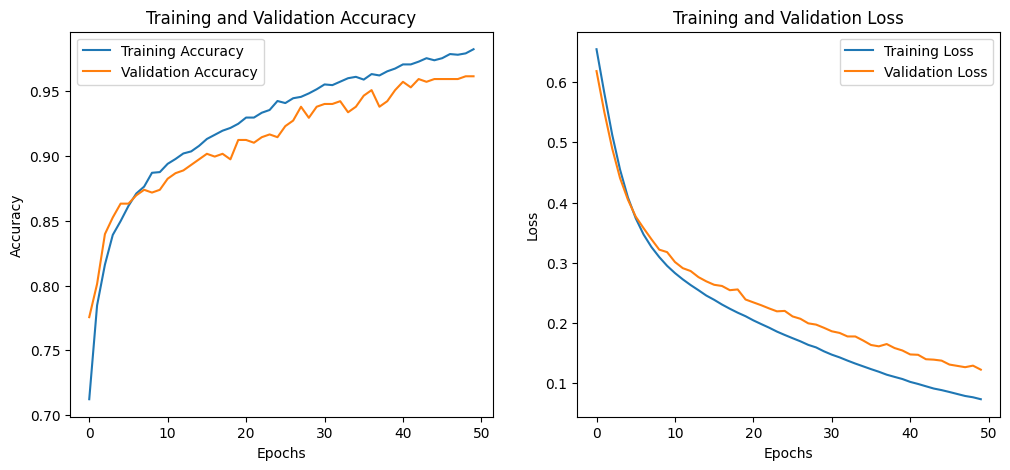

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Precision: 97.36%
Recall: 97.35%
F1-score: 97.35%


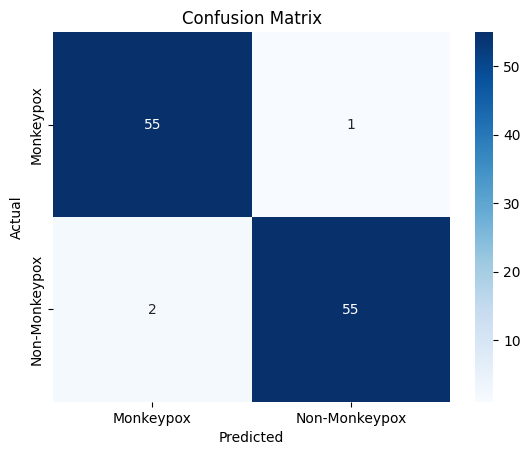

Model: "res_net_with_multihead_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ multihead_attention_layer       │ ?                      │     2,099,968 │
│ (MultiheadAttentionLayer)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 750)            │     1,536,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,502 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,225,934 (103.86 MB)

 Trainable params: 3,638,220 (13.88 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Multihead Attention Layer
class MultiheadAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super().__init__(**kwargs)
        self.multihead_attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)

    def call(self, query, key, value):
        return self.multihead_attention(query, key, value)

# Custom ResNet Model with Multihead Attention
class ResNetWithMultiheadAttention(tf.keras.Model):
    def __init__(self, base_model, num_heads=4, key_dim=64, num_classes=2, **kwargs):
        super().__init__(**kwargs)
        self.base_model = base_model
        self.attention_layer = MultiheadAttentionLayer(num_heads=num_heads, key_dim=key_dim)
        self.global_avg_pool = layers.GlobalAveragePooling2D()
        self.dropout = layers.Dropout(0.5)
        self.dense1 = layers.Dense(750, activation='relu')
        self.dense2 = layers.Dense(num_classes, activation='softmax')

    def call(self, inputs):
        features = self.base_model(inputs, training=False)
        query = tf.expand_dims(features, axis=1)
        attention_output = self.attention_layer(query, query, query)
        attention_output = tf.squeeze(attention_output, axis=1)
        x = self.global_avg_pool(attention_output)
        x = self.dropout(x)
        x = self.dense1(x)
        return self.dense2(x)

# Instantiate the base ResNet50 model
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(256, 256, 3),
    pooling=None,
    weights='imagenet'
)

# Create an instance of the custom model
model = ResNetWithMultiheadAttention(base_model=base_model)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(
    optimizer=SGD(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Load dataset
train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/Monkeypox_Skin_Image_Dataset/normalized/train',
    image_size=(256, 256),
    batch_size=32
)
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/Monkeypox_Skin_Image_Dataset/normalized/validation',
    image_size=(256, 256),
    batch_size=32
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/Monkeypox_Skin_Image_Dataset/normalized/test',
    image_size=(256, 256),
    batch_size=32
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

validation_loss, validation_accuracy = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {validation_accuracy * 100:.2f}%")

# Plot Accuracy and Loss (Fig. 4)
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

# Evaluate on test dataset
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate Precision, Recall, and F1-score
precision = precision_score(y_true, y_pred, average='weighted') * 100
recall = recall_score(y_true, y_pred, average='weighted') * 100
f1 = f1_score(y_true, y_pred, average='weighted') * 100

print(f'Precision: {precision:.2f}%')
print(f'Recall: {recall:.2f}%')
print(f'F1-score: {f1:.2f}%')

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Monkeypox', 'Non-Monkeypox'], yticklabels=['Monkeypox', 'Non-Monkeypox'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

model.summary()
